# Community

Here we quickly show an example of the package applied to the same metabolic models as before.

In [1]:
from ncmw.utils import get_models
from ncmw.community import BagOfReactionsModel, ShuttleCommunityModel
from ncmw.setup_models import set_default_configs_and_snm3_medium
models = get_models("models")
for i in range(len(models)):
    models[i] = set_default_configs_and_snm3_medium(models[i])

## Bag of reaction model

This very simple approach models the community as union of all reactions and metabolites of it's members. 

In [23]:
bag_model = BagOfReactionsModel(models)

In [24]:
_, growths, _ = bag_model.optimize()
for m, g in zip(models, growths):
    print(f"{m.id.split(sep='_')[0]} achives {g} biomass rate")

CarveMe achives 0.0 biomass rate
himodel achives 0.0 biomass rate
Staphylococcus achives 7.1101761769386655 biomass rate
DP achives 0.0 biomass rate
iYS854 achives 0.0 biomass rate


Mh, so as we can see the maximum growth rate for the community is achived if Staphylooccus outcompetes all other species. This may seems unrealistic. On think we can do is to "enforce" that any member of the comunity must grow at leat 1% of the total growth rate. So lets do this.

In [26]:
_, growths, _ = bag_model.optimize(enforce_survival=0.01)
for m, g in zip(models, growths):
    print(f"{m.id.split(sep='_')[0]} achives {g} biomass rate")

CarveMe achives 0.01409576405803922 biomass rate
himodel achives 6.9914989727874515 biomass rate
Staphylococcus achives 0.01409576405803922 biomass rate
DP achives 0.01409576405803922 biomass rate
iYS854 achives 0.01409576405803922 biomass rate


Intestingly suddenly himodel achives most growth. Unforunatly with the BagOfReactions we cannot analyze the interactions more deeply. So lets look at the ShuttleCommunityModel

## ShuttleCommunityModel

Here any community member is seperated in own compartments, but they can interact over an external environment through so called "shuttle reactions".

In [27]:
model = ShuttleCommunityModel(models)

In [31]:
_, growths, _ = model.optimize()
for m, g in zip(models, growths):
    print(f"{m.id.split(sep='_')[0]} achives {g} biomass rate")

CarveMe achives 0.051665019814527126 biomass rate
himodel achives 0.6220373234175469 biomass rate
Staphylococcus achives 0.03595262970433371 biomass rate
DP achives 0.13562384271818156 biomass rate
iYS854 achives 5.020210990276516 biomass rate


In [41]:
from ncmw.visualization import plot_pairwise_growth_relation_per_weight, plot_community_interaction, plot_community_summary, plot_community_uptake_graph

## Pairwise community interaction

Here we plot the growth of each model, given the weight $\alpha$. This shows e.g. at which weight the community is balanced between two species.

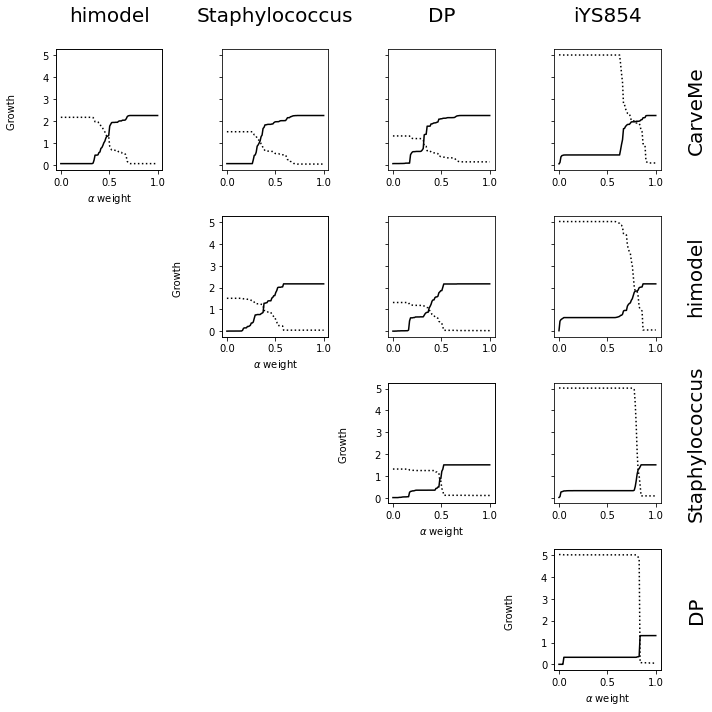

In [6]:
_ = plot_pairwise_growth_relation_per_weight(model)

# Community summary

Lets look on the flux summary for the community.

Objective:  5.8654898059311025
CarveMe_SNM_gapfilled_model :  0.05166501981452745  with weights  1
himodel :  0.6220373234175436  with weights  1
Staphylococcus_epidermidis_ATCC_12228 :  0.035952629704333695  with weights  1
DP_83VPs_KB5 :  0.13562384271818181  with weights  1
iYS854 :  5.020210990276516  with weights  1


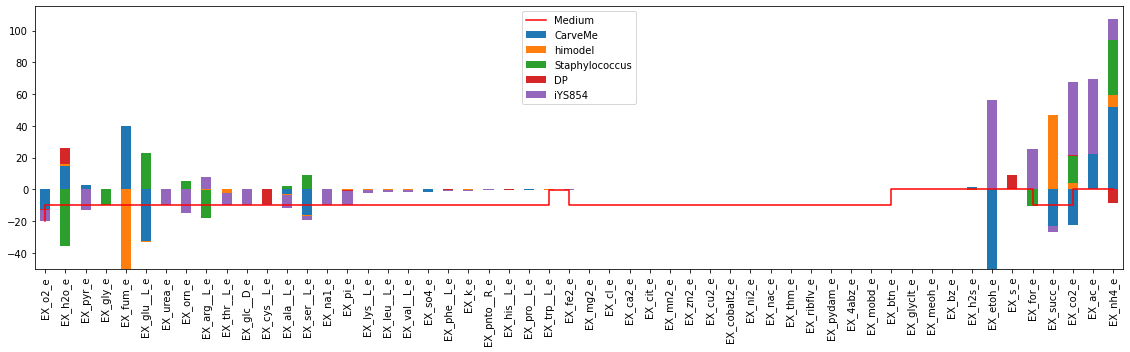

In [44]:
summary = model.summary()
f = plot_community_summary(model, summary)

This plot now actually contains most of the information. The red line shows the medium, everythink below the red line must be provide by other community members indicating a positive interaction between this species see e.g. EX_h20_e. That's cool, but we can visualize it more explicitly.

## Community interaction

Here we plot the internal exchanges between the community members.

c:\users\manug\desktop\ncmw projects\ncmw\ncmw\community\community_analysis.py:95: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(df.columns[-1], 1)


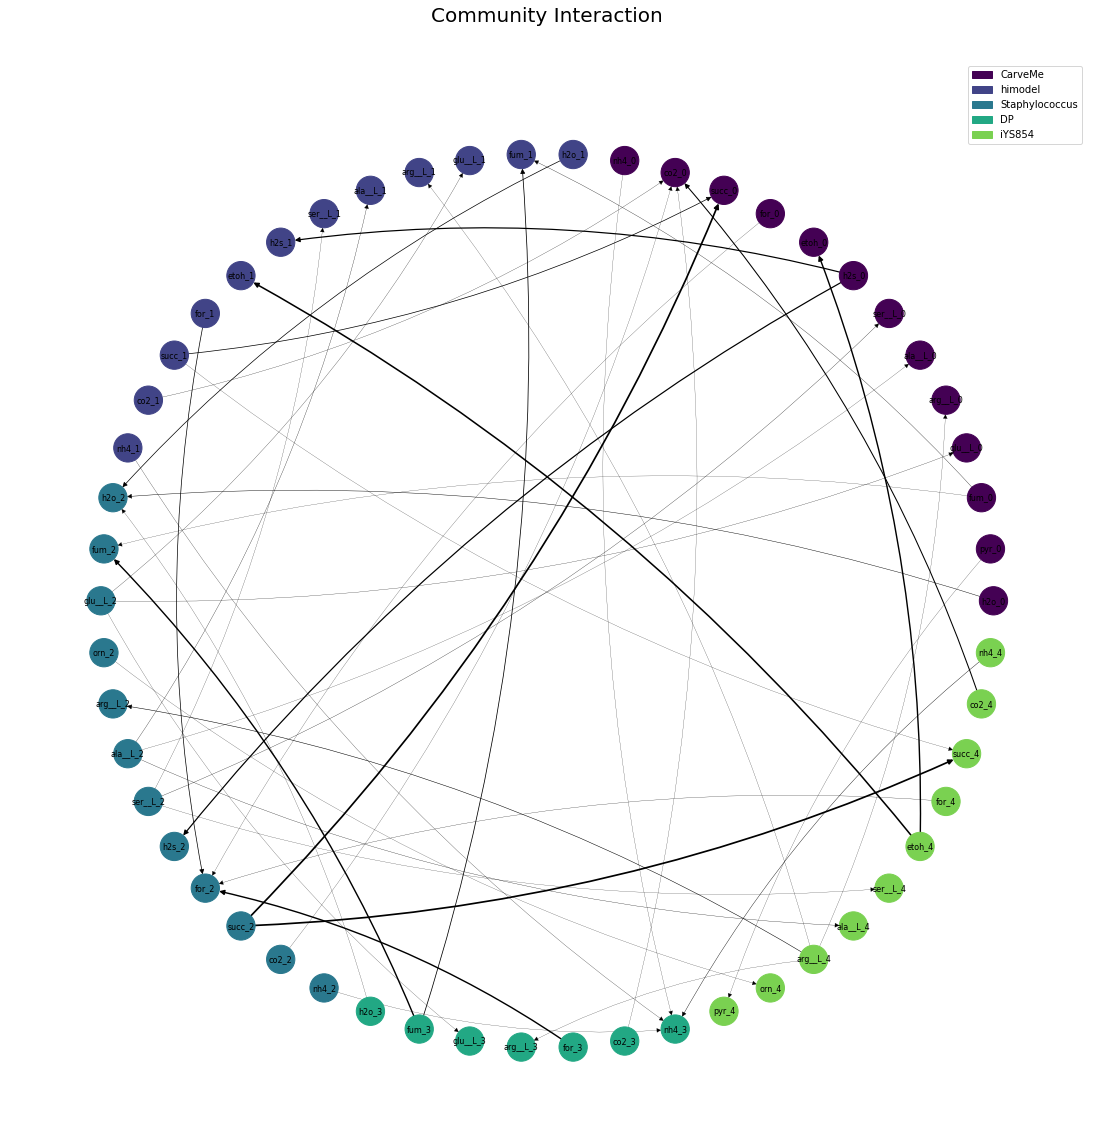

In [45]:
fig = plot_community_interaction(model, summary)

C:\Users\manug\.conda\envs\ncmw\lib\site-packages\matplotlib\cbook\__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


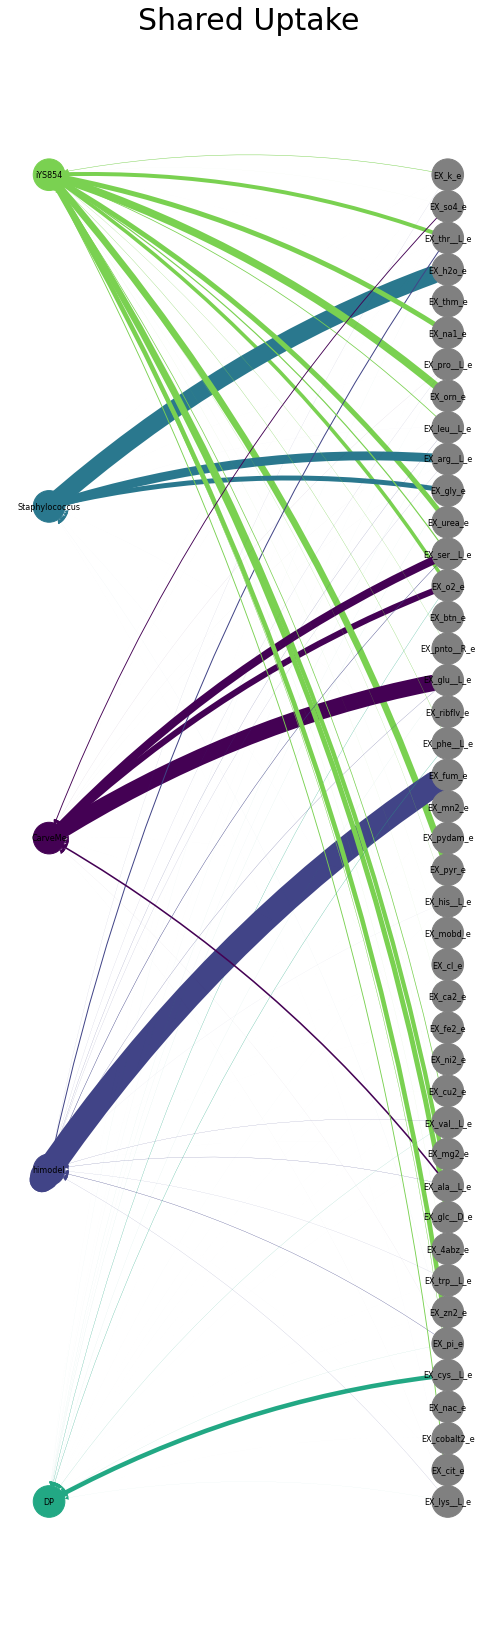

In [46]:
f = plot_community_uptake_graph(model, summary)

## Cooperative tradeoff

We can see that still one of the models dominates the community. One way to obtain a more "balanced" community growth is to enable cooperative tradeoff.

Objective:  4.692391844744882
CarveMe_SNM_gapfilled_model :  0.9773530526679227  with weights  1
himodel :  0.8909101273531143  with weights  1
Staphylococcus_epidermidis_ATCC_12228 :  0.2668679429482054  with weights  1
DP_83VPs_KB5 :  0.13071016867880741  with weights  1
iYS854 :  2.426550553096832  with weights  1


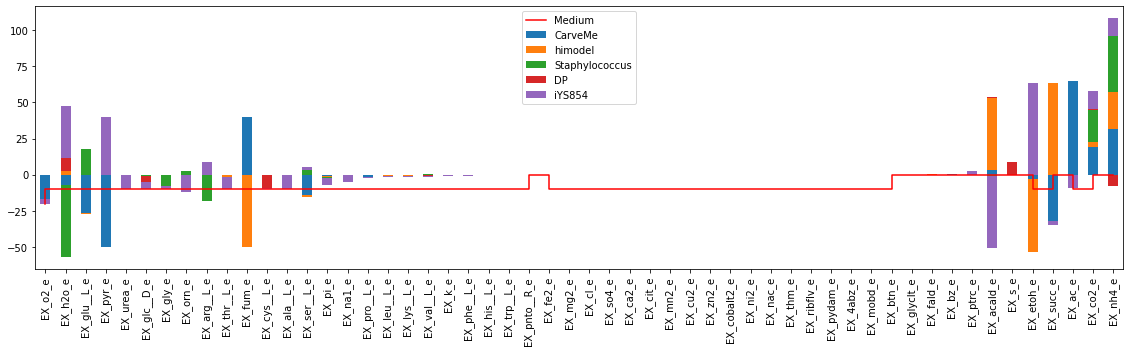

In [48]:
summary = model.summary(cooperative_tradeoff=0.8)
f = plot_community_summary(model, summary)

## COOPM

Last but not least we may are intersted at different medias. The COOPM (cooperation inducing medium) is made such that all members in the community survive with atleast 10 % of their maximum growth rate. But also tries to minimize the number of metabolites within the medium. This induces a large number of cooperations, within the community as we see here:

Objective:  0.5872950746859743
CarveMe_SNM_gapfilled_model :  3.3985685918895583e-06  with weights  1
himodel :  0.4678036276939182  with weights  1
Staphylococcus_epidermidis_ATCC_12228 :  0.0009907973165895316  with weights  1
DP_83VPs_KB5 :  0.01587568218499348  with weights  1
iYS854 :  0.1026215689218812  with weights  1


c:\users\manug\desktop\ncmw projects\ncmw\ncmw\community\community_analysis.py:95: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(df.columns[-1], 1)


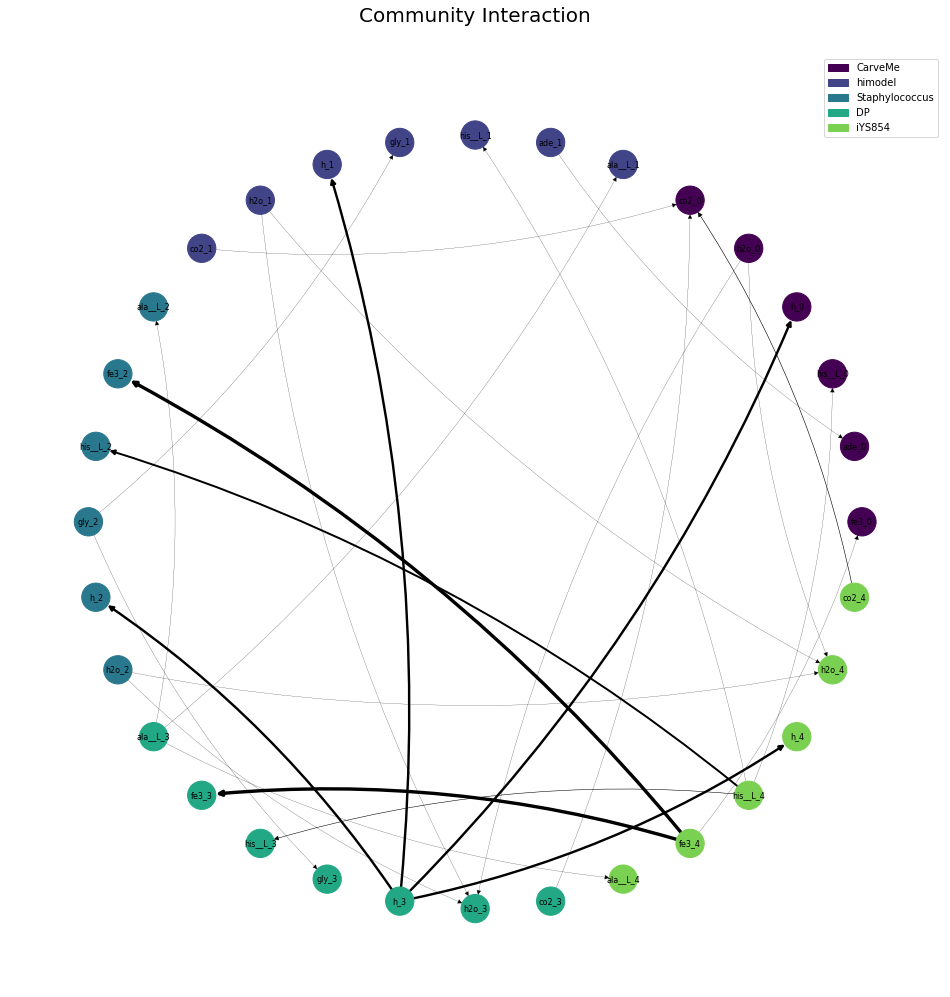

In [49]:
coopm = model.compute_COOPM(model.slim_optimize())
model.medium = coopm 
fig = plot_community_interaction(model, model.summary())

Thats now much less crowded. We found a very small medium on which all community members can have growth!

In [50]:
coopm

{'EX_ala__L_e': 10.0,
 'EX_cl_e': 0.0038041212862475766,
 'EX_k_e': 0.10851794904623399,
 'EX_ca2_e': 0.0031882818826025933,
 'EX_mg2_e': 0.006146127456829589,
 'EX_mn2_e': 0.000983263749962264,
 'EX_cobalt2_e': 0.0006066166931445218,
 'EX_zn2_e': 0.0006937151782218333,
 'EX_cu2_e': 0.0008423595903427439,
 'EX_o2_e': 20.0,
 'EX_fe2_e': 0.009302330832123354,
 'EX_mobd_e': 7.183509824529785e-07,
 'EX_so4_e': 0.13681630333999778,
 'EX_nac_e': 2.5577097047429906,
 'EX_thm_e': 0.00014543860266615788,
 'EX_na1_e': 0.2056042659492891,
 'EX_ni2_e': 0.0005635103416296053}